# Top-down Listening
This notebook allows the user to observe audio-visual aspects for a collection of scored recordings filtered based on criteria provided. 
The user can then annotate and/or comment on each recording interactively.

```
Version: 0.2, Date: 12-Jan-2022
Updated By: Khilnani, Jatin
Latest Update: Renewed TDL & random clip extraction methods. Updated help text.
               - All filters and prompts have been updated
               - Works both with and without pooling of dates 
```

## I. Setup

### 1. Import required components

__Pre-requisite:__ [OpenSoundscape](https://opensoundscape.org/en/latest/index.html) installation

In [1]:
# Generic helper components
from glob import glob
from time import sleep
from warnings import warn
from os.path import basename, splitext
from datetime import datetime, timedelta

# data handling and plotting
import pandas as pd
import IPython.display as ipd
from matplotlib import pyplot as plt

# OpSo audio 
from opensoundscape.audiomoth import audiomoth_start_time
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

### 2. Configuration
Update the parameters to provide input & output files/paths and annontation configuration.

#### File locations
- `point_count_card_file`: Comma separated flat file (CSV) containing the list of Audiomoth Card IDs (`sd_card_id`) for which top-down listening is to be performed. The notebook would update the file and add fields Annotation File Name (`annotation_file`) and Annotation (`annotation`) to signify the location of file containing individually annotated audio clips, and overall annotation for the card respectively. Optionally, input file can have a Date (`date`) field which would act as a filter around which listening has to be performed for each card.

- Score files placed at `score_files_dir` are expected to be consistent with ones generated by OpenSoundscape classifiers. One CSV for each Audiomoth Card, and have the Card ID (`sd_card_id`) as part of the filename: <*SD_CARD_ID*.csv>. It should contain at least three fields Audio Clip Filename (`file`), Clip Start Time (`start_time`) and Clip End Time (`end_time`).
  
- Base location for audio files is `audio_dir`. The audio files are supposed to be collated at this location under subfolders, one for which Audiomoth with name as the `sd_card_id` itself.

In [2]:
# input
point_count_card_file = './dfrb2020a_point_counts_and_cards-orig.csv' # full path of the CSV file with card details of each point, updated at same location
score_files_dir = './' # path to CSV files containing classifier scores for each clip - one file for each SD card <*SD_CARD_ID*.csv>
audio_dir = '/Users/jk/Documents/S/CDS/J/UPitt/P' # path to audio clips - containing one folder for each sd_card_id

# output
annotation_save_dir = './annotations' # location where annotated scores file and audio clips would be saved

#### Parameters

Please refer to comments against each parameter.

In [3]:
# file handling
score_col_name = 'present' # which column of predictions file do we want to use as the score? e.g. 'present' for binary classifier
species_name = 'hylocichla-mustelina' # name to be included in the annotation file

# filters
min_score_threshold = 30 # what's the minimum score below which we don't want to listen to a clip? 

valid_annotation = [0,1,2,3,4,5] # valid values for annotation - integer values only for stop_val filter to work
annotation_stop_val = 3 # minimum annotation value to stop annotating particular card at - stop criteria: annotation >= stop_val

included_dates = [-3,-2,-1,0,1,2,3] # if point count date provided in input file, which dates should be included relative to the same? 
                                    # included_dates = [0] will select only the specified date
min_number_of_audio_dates = 1 # if we have scores from less than this many audio clip dates, we will skip listening - default 1

# audio
AUDIO_SAMPLE_RATE = None # None -> don't resample
# CLIP_DURATION = 9 # seconds of clip would like to hear - not functional, commented out

# plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [25,10] # spectrogram / figure size - adjust for your display

### 3. Functions

In [4]:
def add_cols_to_df(cols, df):
    """helper - add (blank) columns to a dataframe 

        Arguments
            cols (list): list of column names to be added. e.g. ['annotation_file', 'annotation', 'comments']
            df (dataframe): target dataframe

        Returns
            dataframe with columns added
    """
    for col in cols:
        if col not in df.columns:
            df[col] = None
            
    return df

#### `annotate_around_pc`
- This function allows user to listen, view spectorgram of and annotate/comment on clips until score threhold or annotation stop value is attained
- Optional date filter to listen a number of days around Point Count Date
- Audio clips can be saved during the process. User can exit mid-process and continue the annotation process
- Missing score/audio files and no records to annotate due to date filters are marked for rectification

In [5]:
def annotate_around_pc(card, date#, included_dates, min_number_of_audio_dates, score_threshold, 
                       #annotation_stop_val, score_files_dir, audio_dir, annotation_save_dir,   
                      ):
    """interactive annotation function 

        Arguments
            card (str): Card ID 'sd_card_id' from point count card file, e.g. 'LSD-0243', 'MSD-0017'
            date (datetime.datetime obj): [optional] point count date to act as filter around which 
                                          listening has to be performed, e.g. '2021-06-02'

        Returns
            date (datetime.datetime obj): either input point count date or the date of clip with maximum annotation value
            annotation_file (str): path to annotated score file, e.g.'./annotations/annotations_hylocichla-mustelina_LSD-0243_20210602.csv'
            annotation (int): overall annotation for the card/date pair
    """
    
    try: # check if annotation file exists
        if date:
            annotation_file = f"{annotation_save_dir}/annotations_{species_name}_{card}_{date.replace('-', '')}.csv"
        else:
            annotation_file = f"{annotation_save_dir}/annotations_{species_name}_{card}.csv"
        score_table = pd.read_csv(annotation_file, header=0)
        print(f'Annotation file {annotation_file} exists, continuing annotation.')
        sleep(1.5)
    except FileNotFoundError: # else create from predictions file
        # read score file for this {card}
        SCORE_FILE_COL_NAMES = ['file', 'start_time', 'end_time']
        file_list = glob(f'{score_files_dir}/*{card}*.csv')
        if len(file_list) == 0:
            print(f"Score file not found for card {card}, skipped.")
            return 'FileNotFound', None
        score_table = pd.read_csv(file_list[0], header=0, usecols=SCORE_FILE_COL_NAMES+[score_col_name]).rename(columns={score_col_name:'score'}).query('score >= @min_score_threshold')
        score_table['filename'] = score_table['file'].apply(lambda x: basename(x))
        score_table['date'] = score_table['filename'].apply(lambda x: audiomoth_start_time(x).replace(hour=0, minute=0, second=0, microsecond=0))
                         
        if date:
            # filter to selected dates
            valid_dates = [datetime.strptime(date, '%Y-%m-%d') + timedelta(days=d) for d in included_dates]
            score_table = score_table[score_table['date'].isin(valid_dates)]

        # check for number of score dates available
        n_dates = score_table['date'].nunique()
        if n_dates < min_number_of_audio_dates:
            print(f"Scores found only for {n_dates} date(s), less than {min_number_of_audio_dates} required, skipped.")
            return 'DateFilter', None

        # sort by scores, high to low
        score_table.sort_values(by='score', ascending=False, inplace=True)
        score_table.reset_index(drop=True, inplace=True)
        score_table.reset_index(inplace=True)
        
        score_table = add_cols_to_df(['annotation', 'comments'], score_table)

    # perform/continue annotation
    for score_table_idx, score_table_row in score_table[score_table['annotation'].isnull()].iterrows():
        
        # get the audio clip
        audio_path = f"{audio_dir}/{card}/{score_table_row['filename']}"
        orig_duration = score_table_row['end_time'] - score_table_row['start_time']
        # if orig_duration > CLIP_DURATION:
        #     prompt_input = None
        #     while prompt_input not in ['y', 'N']:
        #         prompt_input = input(f'Requested clip duration ({float(CLIP_DURATION)}s) is less than the scored clip duration ({orig_duration}s). Continue? [y/N]: ')
        #         ipd.clear_output()
        #     if prompt_input == 'N':
        #         score_table.at[score_table_idx,'comments'] = 'DurationFilter'
        #         score_table.to_csv(annotation_file, index=False)
        #         break
        # clip_offset = max(score_table_row['start_t'] - (CLIP_DURATION - orig_duration)/2, 0)
        try:
            audio = Audio.from_file(audio_path, AUDIO_SAMPLE_RATE, offset=score_table_row['start_time'], duration=orig_duration)
        except FileNotFoundError:
            print(f"Audio file {audio_path} not found, skipped.")
            score_table.at[score_table_idx,'comments'] = 'FileNotFound'
            score_table.to_csv(annotation_file, index=False)
            sleep(1)
            continue

        # play sound and wait for user input
        annotation = None
        while annotation not in [str(x) for x in valid_annotation]+['X']:           
                
            ipd.display(ipd.Audio(audio.samples, rate=audio.sample_rate), clear=True)
            print(f"Card: {card}, File: {score_table_row['filename']}, Clip: {score_table_row['index']}")

            # plot spectrogram
            Spectrogram.from_audio(audio).plot() #change spec settings here if necessary

            annotation = input(f"Enter annotation value {valid_annotation}, 'S' (Save audio clip), 'X' (eXit): ")
            if annotation == 'S':
                save_clip_file = f"{annotation_save_dir}/{card}_{splitext(score_table_row['filename'])[0]}_{score_table_row['index']}.wav"
                audio.save(save_clip_file)
                score_table.at[score_table_idx,'comments'] = 'ClipSaved'
                print(f"Clip saved to {save_clip_file}")
                sleep(1.5)

        if annotation == 'X':
            print("User terminated annotation process with 'X'.")
            score_table.at[score_table_idx,'comments'] = 'Exited'
            score_table.to_csv(annotation_file, index=False)
            break
        else: # save annotation
            annotation = int(annotation)
            score_table.at[score_table_idx,'annotation'] = annotation
            score_table.at[score_table_idx,'comments'] = input('Enter comments if any: ') 
            score_table.to_csv(annotation_file, index=False)

            if annotation >= annotation_stop_val:
                print(f'Reached annotation stop value ({annotation_stop_val}).')
                break
                
    # output
    return annotation_file, score_table['annotation'].max()

## II. Annotate

### 1. Load input file in table of point count dates/times

In [6]:
warn('This table will be updated with annotation file name and overall annotation for each record.')
point_count_card_table = add_cols_to_df(['annotation_file', 'annotation'], pd.read_csv(point_count_card_file, header=0))
print(f"\nAnnotation for {point_count_card_file} is required for {point_count_card_table['annotation_file'].count()}/{len(point_count_card_table)} records.")
point_count_card_table


Annotation for ./dfrb2020a_point_counts_and_cards-orig.csv is required for 378/441 records.


/var/folders/58/1n9195_50ydd0168wl3qyfs40000gn/T/ipykernel_8968/2834481241.py:1: UserWarning: This table will be updated with annotation file name and overall annotation for each record.
  warn('This table will be updated with annotation file name and overall annotation for each record.')


,sd_card_id,point_name,Block,Visit,Obs,date,dates deployed,card_upload_date,annotation_file,occupancy,annotation
0,MSD-0017,rk392,SGL089,2.0,ACB,NaN,May 16 - July 9,20200923,./annotations/annotations_hylocichla-mustelina...,3.0,NaN
1,LSD-0286,rk392,SGL089,1.0,BER,2020-05-16 00:00:00,May 16 - July 9,20200923,FileNotFound,NaN,NaN
2,LSD-0273,rk393,SGL089,2.0,CJF,2020-06-01 00:00:00,May 16 - July 9,20200924,./annotations/annotations_hylocichla-mustelina...,3.0,NaN
3,LSD-0273,rk393,SGL089,1.0,CJF,2020-05-15 00:00:00,May 16 - July 9,20200924,FileNotFound,NaN,NaN
4,LSD-0243,rk394,SGL089,2.0,CJF,2020-06-01 00:00:00,May 16 - July 9,20200923,./annotations/annotations_hylocichla-mustelina...,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
436,LSD-0279,rk725,SGL025,1.0,HAP,2020-05-24 00:00:00,May 16 - July 13,20200924,./annotations/annotations_hylocichla-mustelina...,0.0,NaN
437,LSD-0279,rk725,SGL025,2.0,HAP,2020-06-09 00:00:00,May 16 - July 13,20200924,./annotations/annotations_hylocichla-mustelina...,3.0,NaN
438,LSD-0278,rk726,SGL025,1.0,JTL,2020-05-24 00:00:00,May 16 - July 13,20200922,./annotations/annotations_hylocichla-mustelina...,0.0,NaN
439,LSD-0278,rk726,SGL025,2.0,HAP,2020-06-09 00:00:00,May 16 - July 13,20200922,./annotations/annotations_hylocichla-mustelina...,0.0,NaN


In [7]:
# Optional Step - to restart annotation for particular card/date record make the annotation_file field value blank - if not done in CSV
card_id_list = ['MSD-0017', 'LSD-0243']

for card_id in card_id_list:
    point_count_card_table.at[point_count_card_table['sd_card_id']==card_id, 'annotation_file'] = None
    
point_count_card_table

,sd_card_id,point_name,Block,Visit,Obs,date,dates deployed,card_upload_date,annotation_file,occupancy,annotation
0,MSD-0017,rk392,SGL089,2.0,ACB,NaN,May 16 - July 9,20200923,None,3.0,NaN
1,LSD-0286,rk392,SGL089,1.0,BER,2020-05-16 00:00:00,May 16 - July 9,20200923,FileNotFound,NaN,NaN
2,LSD-0273,rk393,SGL089,2.0,CJF,2020-06-01 00:00:00,May 16 - July 9,20200924,./annotations/annotations_hylocichla-mustelina...,3.0,NaN
3,LSD-0273,rk393,SGL089,1.0,CJF,2020-05-15 00:00:00,May 16 - July 9,20200924,FileNotFound,NaN,NaN
4,LSD-0243,rk394,SGL089,2.0,CJF,2020-06-01 00:00:00,May 16 - July 9,20200923,None,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
436,LSD-0279,rk725,SGL025,1.0,HAP,2020-05-24 00:00:00,May 16 - July 13,20200924,./annotations/annotations_hylocichla-mustelina...,0.0,NaN
437,LSD-0279,rk725,SGL025,2.0,HAP,2020-06-09 00:00:00,May 16 - July 13,20200924,./annotations/annotations_hylocichla-mustelina...,3.0,NaN
438,LSD-0278,rk726,SGL025,1.0,JTL,2020-05-24 00:00:00,May 16 - July 13,20200922,./annotations/annotations_hylocichla-mustelina...,0.0,NaN
439,LSD-0278,rk726,SGL025,2.0,HAP,2020-06-09 00:00:00,May 16 - July 13,20200922,./annotations/annotations_hylocichla-mustelina...,0.0,NaN


### 2. Iterate through each point count that has audio

In [8]:
# loop through each row of the table that doesn't have completed annotation (None/NaN for annotation_file)
# provide the interactive annotation function with the card and date we want to annotate

for pc_idx, pc_row in point_count_card_table[point_count_card_table['annotation_file'].isnull()].iterrows():

    # get card ID & visit date 
    pc_card = pc_row['sd_card_id']
    if 'date' in point_count_card_table.columns and not pd.isna(pc_row['date']):
        pc_date = datetime.strptime(pc_row['date'],'%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
        msg = f', {len(included_dates)} days around {pc_date}'
    else:
        pc_date, msg = None, ''
     
    # check to proceed with annotation
    user_input = None
    while user_input not in ['y','N','X']:
        user_input = input(f"\nProceed with annotation for card {pc_card}{msg}? [y/N/X]: ")
        ipd.clear_output()
    if user_input == 'y':
        annotation_file, annotation = annotate_around_pc(pc_card, pc_date#, included_dates, min_number_of_audio_dates, \
                                                         #score_threshold, score_files_dir, audio_dir, annotation_save_dir
                                                        )
            
        # save annotation
        point_count_card_table.at[pc_idx,'annotation_file'] = annotation_file
        point_count_card_table.at[pc_idx,'annotation'] = annotation

        point_count_card_table.to_csv(point_count_card_file, index=False)
        
        if annotation_file not in ['FileNotFound', 'DateFilter']:
            print(f"Annotation for card {pc_card}{msg} saved at {annotation_file}")
            
    elif user_input == 'X':
        print("User terminated annotation process with 'X'.")
        break
    
print(f"\nAnnotation for {point_count_card_file} is complete for {point_count_card_table['annotation_file'].count()}/{len(point_count_card_table)} records.")

User terminated annotation process with 'X'.

Annotation for ./dfrb2020a_point_counts_and_cards-orig.csv is complete for 378/441 records.


In [10]:
# check progress (saved in original CSV)
point_count_card_table

,sd_card_id,point_name,Block,Visit,Obs,date,dates deployed,card_upload_date,annotation_file,occupancy,annotation
0,MSD-0017,rk392,SGL089,2.0,ACB,NaN,May 16 - July 9,20200923,DateFilter,3.0,NaN
1,LSD-0286,rk392,SGL089,1.0,BER,2020-05-16 00:00:00,May 16 - July 9,20200923,FileNotFound,NaN,NaN
2,LSD-0273,rk393,SGL089,2.0,CJF,2020-06-01 00:00:00,May 16 - July 9,20200924,./annotations/annotations_hylocichla-mustelina...,3.0,NaN
3,LSD-0273,rk393,SGL089,1.0,CJF,2020-05-15 00:00:00,May 16 - July 9,20200924,FileNotFound,NaN,NaN
4,LSD-0243,rk394,SGL089,2.0,CJF,2020-06-01 00:00:00,May 16 - July 9,20200923,None,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
436,LSD-0279,rk725,SGL025,1.0,HAP,2020-05-24 00:00:00,May 16 - July 13,20200924,./annotations/annotations_hylocichla-mustelina...,0.0,NaN
437,LSD-0279,rk725,SGL025,2.0,HAP,2020-06-09 00:00:00,May 16 - July 13,20200924,./annotations/annotations_hylocichla-mustelina...,3.0,NaN
438,LSD-0278,rk726,SGL025,1.0,JTL,2020-05-24 00:00:00,May 16 - July 13,20200922,./annotations/annotations_hylocichla-mustelina...,0.0,NaN
439,LSD-0278,rk726,SGL025,2.0,HAP,2020-06-09 00:00:00,May 16 - July 13,20200922,./annotations/annotations_hylocichla-mustelina...,0.0,NaN


---
## Extract one audio clip
Pick a random clip of length `CLIP_DURATION` from the provided audio file.

In [26]:
import random

def get_random_clip(audio_path):
    """raises FileNotFoundError if too short or file doesn't exist"""
    # load audio
    # you can adjust audio sample rate if desired
    audio = Audio.from_file(audio_path, sample_rate=AUDIO_SAMPLE_RATE)

    # trim
    if audio.duration() < CLIP_DURATION:
        print(f"audio was too short to extract a clip of length {float(CLIP_DURATION)}s")
        raise FileNotFoundError
    start_time = int(random.uniform(0,audio.duration()-CLIP_DURATION))
    audio = audio.trim(start_time,start_time+CLIP_DURATION)
    return audio, start_time

In [35]:
# input
audio_dir = '/Users/jk/Documents/S/CDS/J/UPitt/P' # path to audio clips

# input
audio_save_dir = './annotations' # path for saving audio clips to

# parameters
card = 'LSD-0243'
date = '20200531' # format: yyyymmdd
file_start_time = '100000' # format: hhmmss

AUDIO_SAMPLE_RATE = None # None -> don't resample
CLIP_DURATION = 20.0 # seconds

In [31]:
# load audio
audio_path = f"{audio_dir}/{card}/{date}_{file_start_time}.WAV"
audio, audio_start_time = get_random_clip(audio_path)
audio

<Audio(samples=(160000,), sample_rate=32000)>

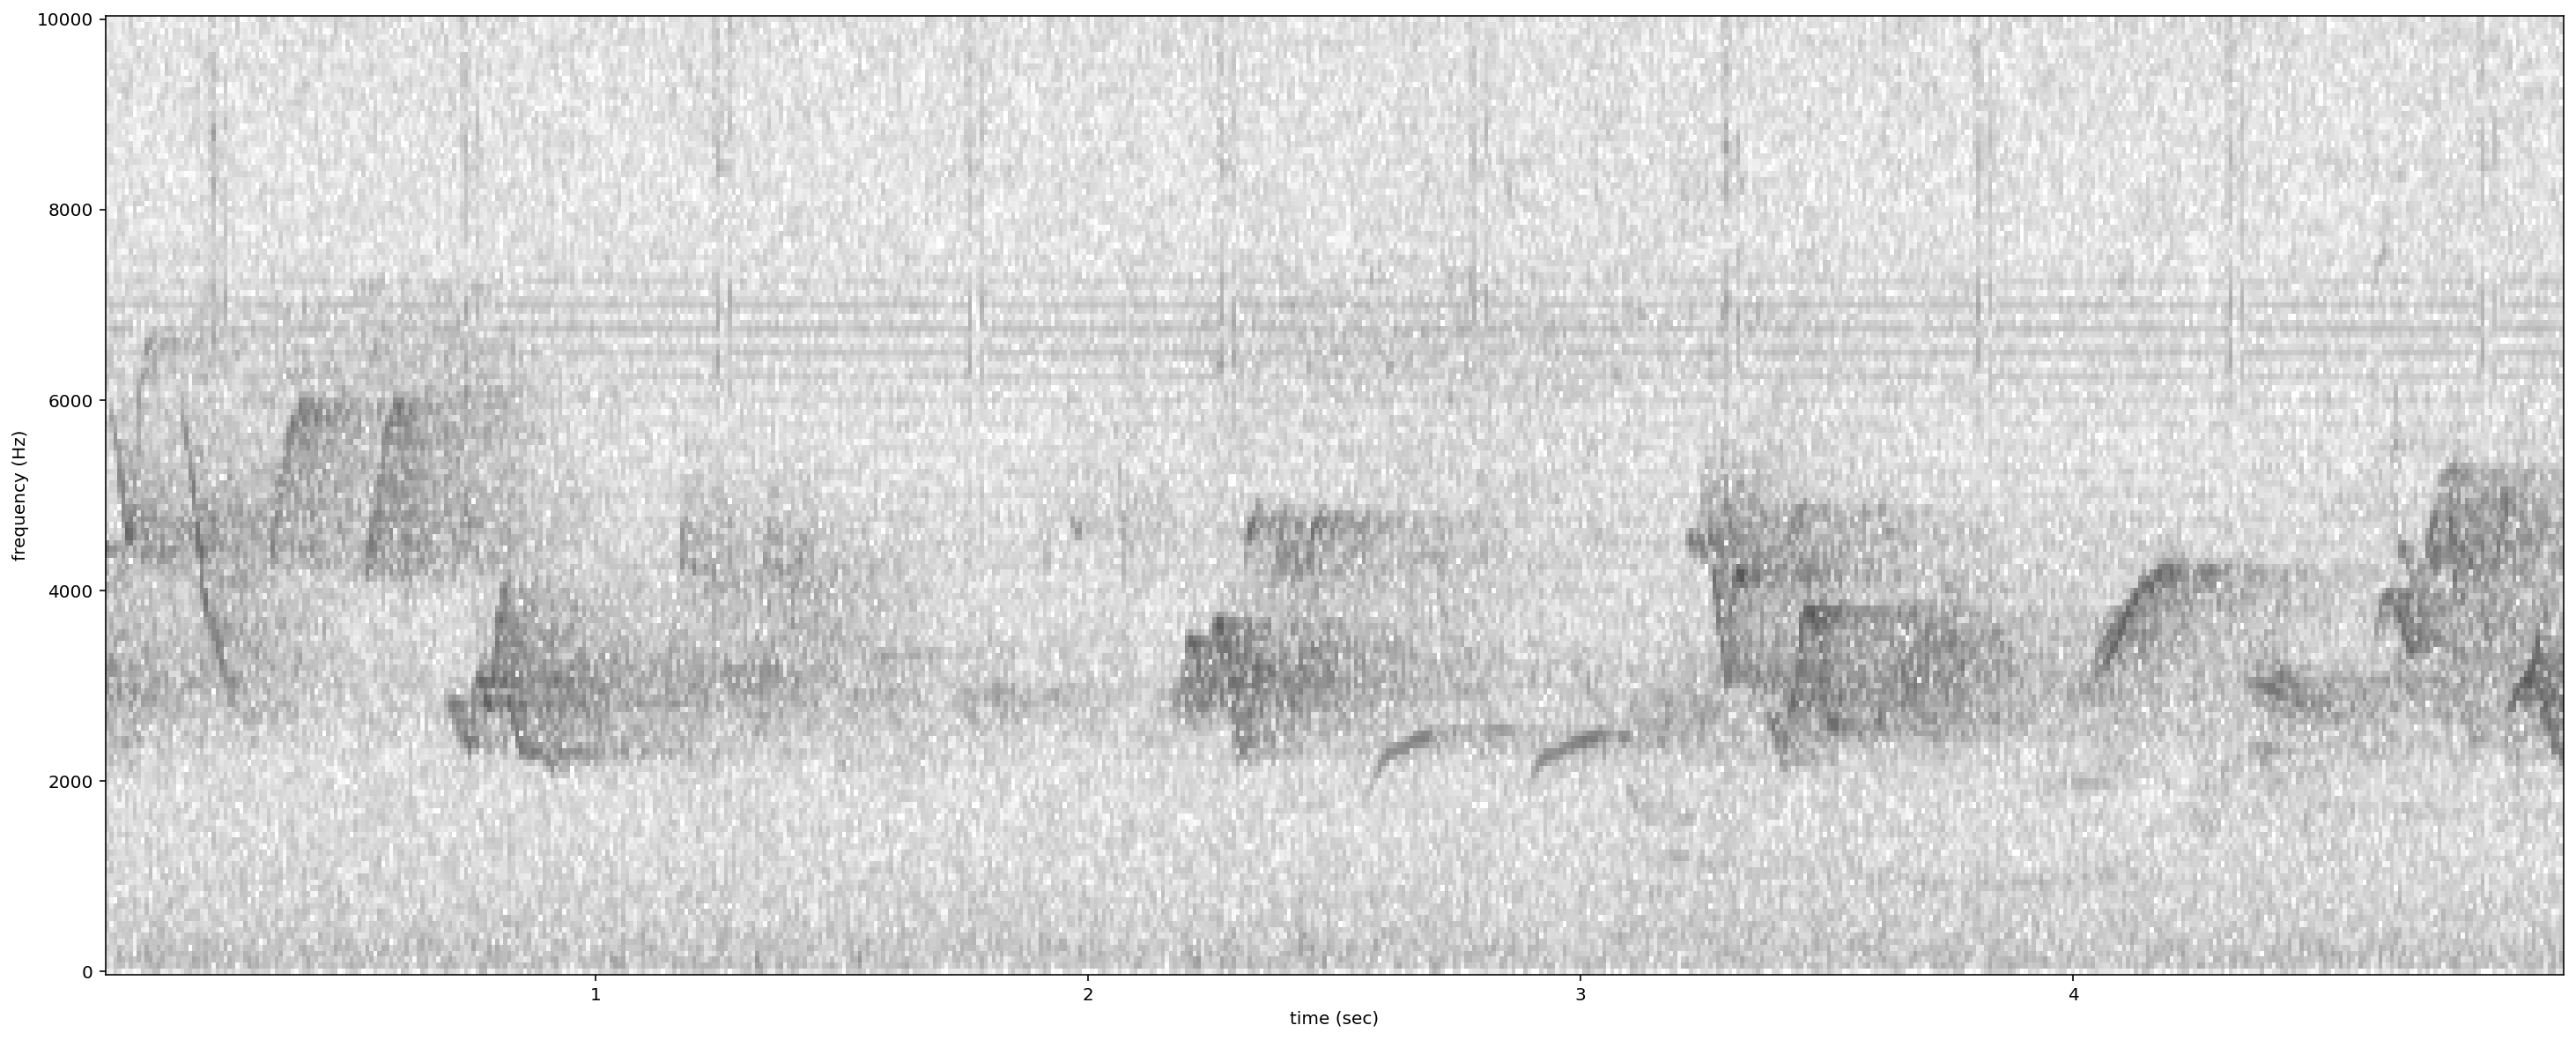

In [32]:
# view spectrogram - you can adjust spectrogram parameters if desired
Spectrogram.from_audio(audio).bandpass(0,10000).plot() 

In [33]:
# play audio
ipd.display(ipd.Audio(audio.samples, rate=audio.sample_rate, autoplay=True), clear=True)

In [34]:
# save audio
audio_save_path = f"{audio_save_dir}/{card}_{date}_{file_start_time}_{audio_start_time}.wav"
audio.save(audio_save_path)

---
[OpenSoundscape](https://opensoundscape.org/en/latest/#) © Copyright 2022, Kitzes Lab